<a href="https://colab.research.google.com/github/Rafal23/Cifar10/blob/master/2_day4_cifar10_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import os

from tensorflow.python.keras.datasets import cifar10
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.python.keras.utils import to_categorical


import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
%matplotlib inline

**Wczytanie danych:**

---



In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape, X_test.shape


170500096/170498071 [==============================] - 52s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3))

**Wizualizacja danych:**

---



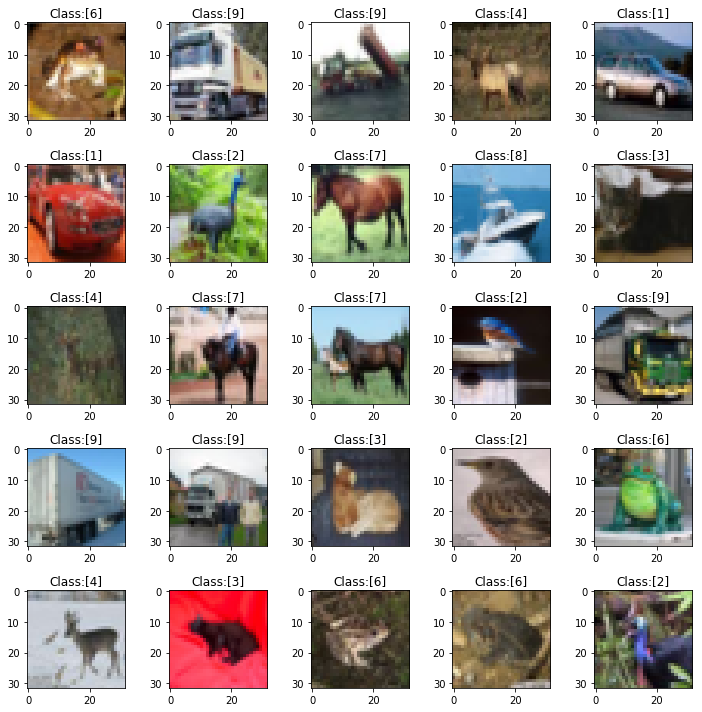

In [0]:
plt.figure(figsize=(10,10))
for idx in range(25):
    plt.subplot(5,5, idx+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title('Class:{}'.format(y_train[idx]))

plt.tight_layout()

**Przekształcanie danych:**

---



In [3]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

num_channels = 3 
X_train = X_train.reshape(X_train.shape[0],img_rows, img_cols, num_channels)
X_test = X_test.reshape(X_test.shape[0],img_rows, img_cols, num_channels)

input_shape = (img_rows, img_cols, num_channels)

X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [0]:
if np.max(X_train) > 1: X_train = X_train/255
if np.max(X_test) > 1: X_test = X_test/255

In [5]:
X_test.min()

0.0

In [0]:
if len(y_train.shape) == 2:
  y_train = y_train.reshape(-1)
  y_test = y_test.reshape(-1)

if len(y_train.shape) == 1:
    num_classes = len(set(y_train))
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

**Tworzenie modelu (architektur):**

---



In [24]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(), #spłaszczenie pomiędzy warstwami konwolucyjnymi, a w całości połączonymi
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
    
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 9, 9, 64)          36928     
__________

In [9]:
y_train.shape, y_test.shape, num_classes

((50000, 10), (10000, 10), 10)

**Łapanie adresu do TPU**

---



In [0]:
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO) # ustawienie poziomu logowania przełaczenie sie z TPU

In [20]:
# zawartość potrzebna do łączenia zTPU:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

INFO:tensorflow:Querying Tensorflow master (grpc://10.29.124.178:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6560526323877288689)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11525686473547457106)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3198246433778955794)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6182054110791709743)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 9998400228796027693)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

**Dopasowywanie modelu:**

---



In [27]:
tpu_model.fit(
    X_train, y_train,
    batch_size=128*8,
    epochs=40,
    verbose=2,
    validation_data=(X_test,y_test),
    validation_split=0.33)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
 - 8s - loss: 0.7002 - acc: 0.7562 - val_loss: 0.8825 - val_acc: 0.6969
Epoch 2/40
 - 8s - loss: 0.6875 - acc: 0.7575 - val_loss: 0.8383 - val_acc: 0.7121
Epoch 3/40
 - 7s - loss: 0.6828 - acc: 0.7606 - val_loss: 1.0659 - val_acc: 0.6495
Epoch 4/40
 - 7s - loss: 0.7010 - acc: 0.7561 - val_loss: 0.9190 - val_acc: 0.6876
Epoch 5/40
 - 7s - loss: 0.6721 - acc: 0.7637 - val_loss: 0.8414 - val_acc: 0.7128
Epoch 6/40
 - 7s - loss: 0.6648 - acc: 0.7642 - val_loss: 0.8410 - val_acc: 0.7108
Epoch 7/40
 - 7s - loss: 0.6590 - acc: 0.7688 - val_loss: 0.8365 - val_acc: 0.7164
Epoch 8/40
 - 7s - loss: 0.6546 - acc: 0.7696 - val_loss: 0.8595 - val_acc: 0.7113
Epoch 9/40
 - 7s - loss: 0.6559 - acc: 0.7683 - val_loss: 0.8841 - val_acc: 0.7077
Epoch 10/40
 - 8s - loss: 0.6548 - acc: 0.7700 - val_loss: 0.9696 - val_acc: 0.6811
Epoch 11/40
 - 7s - loss: 0.6633 - acc: 0.7664 - val_loss: 1.1856 - val_acc: 0.6281
Epoch 12/40
 - 7s - loss: 0.6930 - 

In [30]:
tpu_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 3s 349us/sample - loss: 0.8408 - acc: 0.7250


[0.8407973349571228, 0.72499996]